## Import Libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Lambda, Conv2D, MaxPooling2D, merge, Reshape, regularizers, Activation
from keras.models import Model, model_from_json, load_model, Sequential
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers
from keras.layers.core import Flatten
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.regularizers import l2
from utils import load_data
from numpy import newaxis
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Data Augmentation
#####  rotation = 20, width shift = 0.1, height shit = 0.1, zoom range = 0.2, hotizontal flip
##### among the operations, flip horizontally will improve the performance significanly 


In [2]:
# data augmentation to prevent overfitting and generate more training data
def data_augmentation(batch_size, image_source, classes):
    # tested different ways of data augmentation, flip horizontally will improve the performance significantly
    train_datagen = ImageDataGenerator(
    rotation_range=20.0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    rescale=1.0/255,
    horizontal_flip=True)
    
    # only rescale for testing data
    test_datagen = ImageDataGenerator(rescale=1.0/255)
    
    train_generator = train_datagen.flow_from_directory(
    image_source+"/training",
    target_size=(224,224),
    batch_size=batch_size,
    class_mode="categorical")
    
    validation_generator = test_datagen.flow_from_directory(
    image_source+"/validation",
    target_size=(224,224),
    batch_size=batch_size,
    class_mode="categorical")
    
    return train_generator, validation_generator

## Build Model Architecture
##### VGG16 was selected as the base model. The last COV block feature output was passed into outer product operation with itself to create more features and then the results were passed into the activation layer. 
##### The outer product operation will create more feature combinations, so as to classify more classes. As the problem is a fine grained classification problem, having more features will help recognize the inter-class and intra-class difference.

In [3]:
# Useful functions for bilinear product
def outer_product(x):
    return K.batch_dot(x[0], x[1], axes = [1, 1]) / x[0].get_shape().as_list()[1]
def signed_sqrt(x):
    return K.sign(x)*K.sqrt(K.abs(x) + 1e-9)
def l2_normalize(x, axis = -1):
    return K.l2_normalize(x, axis=axis)

In [4]:
# Model Architecture
def VGG16_outerproduct(classes, dropoutrate, model_name):
    K.clear_session()
    
    # VGG16 as base for extract features
    base_model = VGG16(input_shape = (224, 224, 3), include_top = False, weights = "imagenet")
    for layer in base_model.layers:
        layer.trainable = False
    
    # Get output from VGG16 end layer features
    feature_model_1 = base_model
    x1 = feature_model_1.layers[17].output
    x1_shape = feature_model_1.layers[17].output_shape
    
    feature_model_2 = base_model
    x2 = feature_model_2.layers[17].output
    x2_shape = feature_model_2.layers[17].output_shape
    
    # reshape to (batch_size, total_pixels, filter_size) for outer product
    x1 = Reshape(
        [x1_shape[1]*x1_shape[2], x1_shape[-1]])(x1)
    x2 = Reshape(
        [x2_shape[1]*x2_shape[2], x2_shape[-1]])(x2)
    
    # Outer product of VGG16 features
    x = Lambda(outer_product)([x1, x2])
    x = Reshape([x1_shape[-1]*x2_shape[-1]])(x)
    x = Lambda(signed_sqrt)(x)
    x = Lambda(l2_normalize)(x)
    
    # Final dense layer
    x = Dense(units=len(classes), kernel_initializer="glorot_uniform",
              kernel_regularizer=l2(1e-08),
             bias_initializer="glorot_uniform")(x)
    
    prediction = Activation(activation="softmax")(x)
    
    model = Model(inputs = base_model.input, outputs=prediction)
    
    return model

## Define Tarining Process

##### 1. Fine tune the last layer

In [5]:
# fine tune the last year for initial training
def fine_tune_last_layer(model,train_generator, validation_generator,batch_size, Epochs, model_name, lr, decay, paitence, optimizer_name = "adam"):
    
    if optimizer_name == "adam":
        opt_mizer = Adam(lr = lr)
    elif optimizer_name == "rmsprop":
        opt_mizer = RMSprop(lr = lr)
    elif optimizer_name == "sgd":
        opt_mizer = SGD(lr = lr, decay = decay, momentum=0.9, nesterov= None)
    else:
        raise RuntimeError("Optimizer not found.")
         
    model.compile(optimizer = opt_mizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
    
    # early_stop, reduce_lr and checkpoint
    early_stop = EarlyStopping('val_acc', patience=paitence)
    reduce_lr = ReduceLROnPlateau('val_acc', factor=0.1, patience=int(paitence/4), verbose=1)
    checpoint_dir = os.path.join(model_name + '.{epoch:02d}-{val_acc:.2f}.h5')
    model_checkpoint = ModelCheckpoint(checpoint_dir, monitor='val_acc', verbose=1, save_best_only=True)
    callbacks = [model_checkpoint, early_stop, reduce_lr]
    
    hist = model.fit_generator(
        train_generator, 
        steps_per_epoch = nb_train_samples // batch_size, 
        epochs = Epochs, 
        validation_data = validation_generator, 
        validation_steps = nb_val_samples // batch_size,
        callbacks = callbacks)
    
    model_json = model.to_json()
    with open("final_transfer_learning_" + model_name + ".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights("final_transfer_learning_" + model_name + ".h5")
    print("Saved model.") 

##### 2. Fine tune all layers

In [6]:
# fine tune all layers
def fine_tune_all_layers(model, train_generator, validation_generator, Epochs, model_name, lr, paitence, optimizer_name = "adam"):
    for layer in model.layers:
        layer.trainable = True
    
    if optimizer_name == "adam":
        opt_mizer = Adam(lr = lr)
    elif optimizer_name == "rmsprop":
        opt_mizer = RMSprop(lr = lr)
    elif optimizer_name == "sgd":
        opt_mizer = SGD(lr = lr, momentum=0.9, nesterov= None)
    else:
        raise RuntimeError("Optimizer not found.")
        
    model.compile(optimizer = opt_mizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
    
    early_stop = EarlyStopping('val_acc', patience=paitence)
    reduce_lr = ReduceLROnPlateau('val_acc', factor=0.1, patience=int(paitence/4),verbose=1)
    checpoint_dir = os.path.join("all"+model_name + '.{epoch:02d}-{val_acc:.2f}.h5')
    model_checkpoint = ModelCheckpoint(checpoint_dir, monitor='val_acc', verbose=1, save_best_only=True)
    callbacks = [model_checkpoint, early_stop, reduce_lr]
    
    hist = model.fit_generator(
        train_generator, 
        steps_per_epoch = nb_train_samples // batch_size, 
        epochs = Epochs, 
        validation_data = validation_generator, 
        validation_steps = nb_val_samples // batch_size,
        callbacks = callbacks)
    
    model_json = model.to_json()
    with open("final_all_transfer_learning_" + model_name + ".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights("final_all_transfer_learning_" + model_name + ".h5")
    print("Saved model.") 
    
    return hist

## Fine Tune The Last Layer

##### 1. Set Hyperparameters for initial training, "SGD" was selected as the optimizer with learning rate = 0.1 and decay = 1e-8. Batchsize = 64, Epochs = 500.
##### 2. Load training data and validation data using real time augmentation, training size = 6509, validation size = 1635.
##### 3. Initialize VGG16_outerproduct model and only train the last layers.

In [7]:
# hyperparameters for initial training
lr = 0.1
epochs = 500
dropout_rate  = 0.5
batch_size = 64
model_name = "VGG19"
paitence = 10
optimizer_name = "sgd"
decay = 1e-8

In [8]:
classes = load_data("devkit/cars_meta.mat", "class", "train")

In [9]:
# get trainning and validation data
train_generator, validation_generator = data_augmentation(batch_size=batch_size, image_source="data/",classes=classes)

Found 6509 images belonging to 196 classes.
Found 1635 images belonging to 196 classes.


In [10]:
nb_train_samples = 6509
nb_val_samples = 1635  

In [11]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True    # to allow gpu growth
session = tf.Session(config=config)
K.set_session(session)

In [12]:
# load model
model = VGG16_outerproduct(classes=classes,dropoutrate=dropout_rate,model_name=model_name)

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
# fine tunning last layer
fine_tune_last_layer(model=model, train_generator=train_generator, validation_generator=validation_generator, batch_size=batch_size,Epochs=epochs,lr=lr,decay =decay,model_name=model_name,paitence=paitence, optimizer_name=optimizer_name)

Instructions for updating:
Use tf.cast instead.
Epoch 1/500
101/101 [==============================] - 86s 852ms/step - loss: 5.3007 - acc: 0.0053 - val_loss: 5.2724 - val_acc: 0.0088

Epoch 00001: val_acc improved from -inf to 0.00875, saving model to VGG19.01-0.01.h5
Epoch 2/500
101/101 [==============================] - 86s 851ms/step - loss: 5.2746 - acc: 0.0084 - val_loss: 5.2594 - val_acc: 0.0083

Epoch 00002: val_acc did not improve from 0.00875
Epoch 3/500
101/101 [==============================] - 81s 803ms/step - loss: 5.2633 - acc: 0.0082 - val_loss: 5.2484 - val_acc: 0.0089

Epoch 00003: val_acc improved from 0.00875 to 0.00891, saving model to VGG19.03-0.01.h5
Epoch 4/500
101/101 [==============================] - 81s 804ms/step - loss: 5.2545 - acc: 0.0076 - val_loss: 5.2432 - val_acc: 0.0089

Epoch 00004: val_acc did not improve from 0.00891
Epoch 5/500
101/101 [==============================] - 80s 791ms/step - loss: 5.2452 - acc: 0.0091 - val_loss: 5.2343 - val_acc: 0.

## Fine Tune All Layers

##### 1. Set Hyperparameters for training, "ADAM" was selected as the optimizer with learning rate = 0.0001 and no decay. Batchsize = 64, Epochs = 500.
##### 2. The best model results achieved 99% training accuracy, 89.2% validation accuracy and 87.8 testing accuracy.

In [14]:
#load model from pre-trained
#load json and create model
json_file = open("final_transfer_learning_VGG16.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("final_transfer_learning_VGG16.h5")
print('Loaded model from disk')

Loaded model from disk


In [15]:
# hyperparameters for fine tune all layers
lr = 0.0001
epochs = 500
dropout_rate  = 0.5
batch_size = 64
model_name = "VGG16"
paitence = 20
optimizer_name = "adam"

In [16]:
history = fine_tune_all_layers(model = model, train_generator = train_generator, validation_generator = validation_generator, Epochs = epochs, model_name = model_name, lr = lr, paitence = paitence, optimizer_name = optimizer_name)

Epoch 1/500
101/101 [==============================] - 91s 903ms/step - loss: 5.0437 - acc: 0.0438 - val_loss: 4.7548 - val_acc: 0.1229

Epoch 00001: val_acc improved from -inf to 0.12285, saving model to allVGG19.01-0.12.h5
Epoch 2/500
101/101 [==============================] - 87s 862ms/step - loss: 4.4408 - acc: 0.1767 - val_loss: 4.0935 - val_acc: 0.2896

Epoch 00002: val_acc improved from 0.12285 to 0.28962, saving model to allVGG19.02-0.29.h5
Epoch 3/500
101/101 [==============================] - 88s 868ms/step - loss: 3.8115 - acc: 0.3093 - val_loss: 3.5068 - val_acc: 0.4157

Epoch 00003: val_acc improved from 0.28962 to 0.41566, saving model to allVGG19.03-0.42.h5
Epoch 4/500
101/101 [==============================] - 90s 887ms/step - loss: 3.2490 - acc: 0.4416 - val_loss: 2.9803 - val_acc: 0.4825

Epoch 00004: val_acc improved from 0.41566 to 0.48250, saving model to allVGG19.04-0.48.h5
Epoch 5/500
101/101 [==============================] - 87s 864ms/step - loss: 2.7354 - acc:

##### Training history

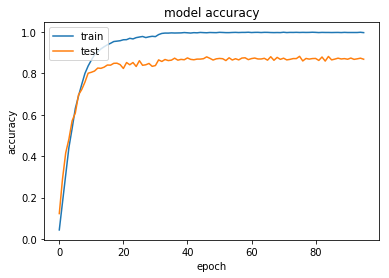

In [20]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

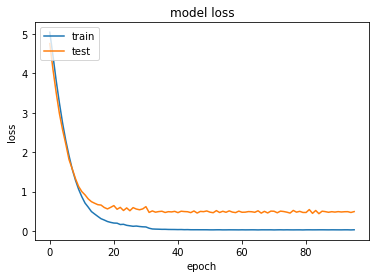

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Reference
##### 1. Bilinear CNN Models for Fine-grained Visual Recognition，http://vis-www.cs.umass.edu/bcnn/docs/bcnn_iccv15.pdf
##### 2. https://github.com/tkhs3/BCNN_keras